In [ ]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All imports successful


In [ ]:
# Cell 2: Load dataset paths
base_path = Path('/home/tigerit/Documents/face-liveliness/casia-fasd')

# TRAIN SET
train_real_images = sorted(list((base_path / 'train/live').glob('*.png')))
train_spoof_images = sorted(list((base_path / 'train/spoof').glob('*.png')))

# TEST SET
test_real_images = sorted(list((base_path / 'test/live').glob('*.png')))
test_spoof_images = sorted(list((base_path / 'test/spoof').glob('*.png')))

print("="*60)
print("DATASET STRUCTURE")
print("="*60)
print(f"TRAIN: Real={len(train_real_images)}, Spoof={len(train_spoof_images)}")
print(f"TEST:  Real={len(test_real_images)}, Spoof={len(test_spoof_images)}")
print("="*60)

DATASET STRUCTURE
TRAIN SET:
  Real:  19011 images
  Spoof: 38736 images
  Total: 57747 images

TEST SET:
  Real:  10128 images
  Spoof: 55658 images
  Total: 65786 images


In [ ]:
# Cell 3: FFT Feature Extraction (Original 8 features)
def compute_radial_profile(magnitude_spectrum):
    """Compute radial average of frequency spectrum"""
    h, w = magnitude_spectrum.shape
    center = (h // 2, w // 2)
    
    y, x = np.ogrid[:h, :w]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(int)
    
    max_r = min(center)
    radial_prof = np.zeros(max_r)
    
    for radius in range(max_r):
        mask = (r == radius)
        radial_prof[radius] = magnitude_spectrum[mask].mean() if mask.any() else 0
    
    return radial_prof


def extract_fft_features(image_path, img_size=256):
    """Extract FFT-based liveness features"""
    try:
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        
        img = cv2.resize(img, (img_size, img_size))
        
        # Compute FFT
        f_transform = np.fft.fft2(img)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.abs(f_shift)
        
        # Radial profile
        radial_prof = compute_radial_profile(magnitude)
        
        # Frequency band analysis
        h, w = magnitude.shape
        center = (h // 2, w // 2)
        
        y, x = np.ogrid[:h, :w]
        r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        
        outer_radius = int(min(center) * 0.8)
        inner_radius = int(min(center) * 0.5)
        low_radius = int(min(center) * 0.3)
        
        high_freq_mask = (r >= inner_radius) & (r <= outer_radius)
        low_freq_mask = r < low_radius
        
        high_freq_energy = magnitude[high_freq_mask].sum()
        low_freq_energy = magnitude[low_freq_mask].sum()
        total_energy = magnitude.sum()
        
        features = {
            'high_freq_energy': high_freq_energy,
            'low_freq_energy': low_freq_energy,
            'high_low_ratio': high_freq_energy / (low_freq_energy + 1e-10),
            'high_freq_percentage': (high_freq_energy / total_energy) * 100,
            'radial_profile_mean': radial_prof.mean(),
            'radial_profile_std': radial_prof.std(),
            'radial_profile_slope': np.polyfit(range(len(radial_prof)), radial_prof, 1)[0],
            'total_energy': total_energy,
        }
        
        return features
    
    except Exception as e:
        print(f"Error: {e}")
        return None

print("✓ FFT feature extraction defined (8 features)")

✓ Radial profile function defined


In [ ]:
# Cell 4: Extract features from TRAIN set
print("Extracting TRAIN features...")

train_real_features = [extract_fft_features(p) for p in tqdm(train_real_images, desc="Train Real")]
train_real_features = [f for f in train_real_features if f is not None]

train_spoof_features = [extract_fft_features(p) for p in tqdm(train_spoof_images, desc="Train Spoof")]
train_spoof_features = [f for f in train_spoof_features if f is not None]

train_real_df = pd.DataFrame(train_real_features)
train_real_df['label'] = 1

train_spoof_df = pd.DataFrame(train_spoof_features)
train_spoof_df['label'] = 0

train_df = pd.concat([train_real_df, train_spoof_df], ignore_index=True)

print(f"✓ Train: {len(train_df)} samples (Real={len(train_real_df)}, Spoof={len(train_spoof_df)})")

✓ Enhanced FFT feature extraction defined
  Features: 32 FFT-based features


In [ ]:
# Cell 5: Extract features from TEST set
print("Extracting TEST features...")

test_real_features = [extract_fft_features(p) for p in tqdm(test_real_images, desc="Test Real")]
test_real_features = [f for f in test_real_features if f is not None]

test_spoof_features = [extract_fft_features(p) for p in tqdm(test_spoof_images, desc="Test Spoof")]
test_spoof_features = [f for f in test_spoof_features if f is not None]

test_real_df = pd.DataFrame(test_real_features)
test_real_df['label'] = 1

test_spoof_df = pd.DataFrame(test_spoof_features)
test_spoof_df['label'] = 0

test_df = pd.concat([test_real_df, test_spoof_df], ignore_index=True)

print(f"✓ Test: {len(test_df)} samples (Real={len(test_real_df)}, Spoof={len(test_spoof_df)})")

✓ LBP feature extraction defined
  Features: 18 texture-based features


In [ ]:
# Cell 6: Prepare data for KAN
feature_cols = ['high_freq_energy', 'low_freq_energy', 'high_low_ratio', 
                'high_freq_percentage', 'radial_profile_mean', 'radial_profile_std', 
                'radial_profile_slope', 'total_energy']

X_train = train_df[feature_cols].values
y_train = train_df['label'].values

X_test = test_df[feature_cols].values
y_test = test_df['label'].values

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

print(f"Train: {X_train_tensor.shape}, Test: {X_test_tensor.shape}")

✓ Combined feature extractor ready
  Total features: ~50 (32 FFT + 18 LBP)


In [ ]:
# Cell 7: Implement KAN (Kolmogorov-Arnold Network)
class KANLayer(nn.Module):
    """
    KAN Layer: Learnable activation functions on edges
    Instead of fixed activations, we learn spline-based functions
    """
    def __init__(self, input_dim, output_dim, num_knots=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_knots = num_knots
        
        # Learnable spline coefficients for each edge
        # Shape: [output_dim, input_dim, num_knots]
        self.spline_coeffs = nn.Parameter(
            torch.randn(output_dim, input_dim, num_knots) * 0.1
        )
        
        # Knot positions (fixed, evenly spaced)
        self.register_buffer('knots', torch.linspace(-3, 3, num_knots))
        
        # Residual connection weight
        self.residual_weight = nn.Parameter(torch.randn(output_dim, input_dim) * 0.1)
        
    def basis_function(self, x, knot_idx):
        """B-spline basis function"""
        # Simplified linear basis for interpretability
        if knot_idx == 0:
            return torch.relu(self.knots[1] - x)
        elif knot_idx == self.num_knots - 1:
            return torch.relu(x - self.knots[-2])
        else:
            left = torch.relu(x - self.knots[knot_idx - 1])
            right = torch.relu(self.knots[knot_idx + 1] - x)
            return torch.min(left, right)
    
    def univariate_function(self, x, out_idx, in_idx):
        """
        Learnable univariate function for edge (in_idx -> out_idx)
        This is the KEY to interpretability!
        """
        result = torch.zeros_like(x)
        
        for k in range(self.num_knots):
            basis = self.basis_function(x, k)
            result += self.spline_coeffs[out_idx, in_idx, k] * basis
        
        # Add residual (linear term)
        result += self.residual_weight[out_idx, in_idx] * x
        
        return result
    
    def forward(self, x):
        """
        x: [batch_size, input_dim]
        output: [batch_size, output_dim]
        """
        batch_size = x.size(0)
        output = torch.zeros(batch_size, self.output_dim, device=x.device)
        
        # For each output neuron
        for out_idx in range(self.output_dim):
            # Sum over all input features with learned functions
            for in_idx in range(self.input_dim):
                output[:, out_idx] += self.univariate_function(
                    x[:, in_idx], out_idx, in_idx
                )
        
        return output
    
    def plot_learned_functions(self, feature_names, neuron_idx=0):
        """Visualize learned univariate functions - KEY FOR INTERPRETABILITY"""
        x_range = torch.linspace(-3, 3, 100)
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        for in_idx in range(self.input_dim):
            with torch.no_grad():
                y_values = torch.zeros(100)
                for i, x_val in enumerate(x_range):
                    y_values[i] = self.univariate_function(
                        x_val.unsqueeze(0), neuron_idx, in_idx
                    )
            
            axes[in_idx].plot(x_range.numpy(), y_values.numpy(), linewidth=2)
            axes[in_idx].set_title(f'{feature_names[in_idx]}', fontsize=10, fontweight='bold')
            axes[in_idx].set_xlabel('Normalized Value')
            axes[in_idx].set_ylabel(f'Contribution to Output')
            axes[in_idx].grid(True, alpha=0.3)
            axes[in_idx].axhline(y=0, color='k', linestyle='--', alpha=0.3)
            axes[in_idx].axvline(x=0, color='k', linestyle='--', alpha=0.3)
        
        plt.suptitle(f'Learned Functions for Neuron {neuron_idx}\n(How each feature affects the output)', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


class KANNetwork(nn.Module):
    """Full KAN Network for Binary Classification"""
    def __init__(self, input_dim, hidden_dim=16, num_knots=5):
        super().__init__()
        
        # Two KAN layers
        self.kan1 = KANLayer(input_dim, hidden_dim, num_knots)
        self.kan2 = KANLayer(hidden_dim, 1, num_knots)
        
        self.feature_names = None
    
    def forward(self, x):
        x = self.kan1(x)
        x = self.kan2(x)
        return torch.sigmoid(x)
    
    def set_feature_names(self, names):
        self.feature_names = names
    
    def visualize_layer1(self):
        """Visualize first layer learned functions"""
        if self.feature_names is None:
            print("Please set feature names first!")
            return
        
        # Show functions for multiple neurons in layer 1
        for neuron_idx in range(min(4, self.kan1.output_dim)):
            print(f"\n{'='*60}")
            print(f"LAYER 1 - NEURON {neuron_idx}")
            print(f"{'='*60}")
            self.kan1.plot_learned_functions(self.feature_names, neuron_idx)

print("✓ KAN architecture defined")

EXTRACTING FEATURES FROM TRAIN SET

Processing TRAIN REAL images...


Train Real: 100%|██████████| 19011/19011 [19:03<00:00, 16.63it/s]



Processing TRAIN SPOOF images...


Train Spoof: 100%|██████████| 38736/38736 [38:28<00:00, 16.78it/s]



✓ Train set processed: 57747 samples
  Real: 19011, Spoof: 38736
  Features extracted: 49


In [ ]:
# Cell 8: Initialize and Train KAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model
model = KANNetwork(input_dim=8, hidden_dim=16, num_knots=7).to(device)
model.set_feature_names(feature_cols)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Calculate class weights for imbalanced data
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))

# Modify model forward to not use sigmoid (BCEWithLogitsLoss includes it)
class KANNetworkLogits(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_knots=5):
        super().__init__()
        self.kan1 = KANLayer(input_dim, hidden_dim, num_knots)
        self.kan2 = KANLayer(hidden_dim, 1, num_knots)
        self.feature_names = None
    
    def forward(self, x):
        x = self.kan1(x)
        x = self.kan2(x)
        return x  # Return logits
    
    def set_feature_names(self, names):
        self.feature_names = names
    
    def visualize_layer1(self):
        if self.feature_names is None:
            return
        for neuron_idx in range(min(4, self.kan1.output_dim)):
            print(f"\n{'='*60}")
            print(f"LAYER 1 - NEURON {neuron_idx}")
            print(f"{'='*60}")
            self.kan1.plot_learned_functions(self.feature_names, neuron_idx)

model = KANNetworkLogits(input_dim=8, hidden_dim=16, num_knots=7).to(device)
model.set_feature_names(feature_cols)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Training loop
num_epochs = 100
train_losses = []
test_accuracies = []

print("\n" + "="*60)
print("TRAINING KAN")
print("="*60)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor.to(device))
        test_preds = (torch.sigmoid(test_outputs) > 0.5).cpu().numpy()
        test_acc = accuracy_score(y_test, test_preds)
        test_accuracies.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}")

print("\n✓ Training complete!")


EXTRACTING FEATURES FROM TEST SET

Processing TEST REAL images...


Test Real: 100%|██████████| 10128/10128 [09:50<00:00, 17.16it/s]



Processing TEST SPOOF images...


Test Spoof: 100%|██████████| 55658/55658 [54:04<00:00, 17.15it/s]



✓ Test set processed: 65786 samples
  Real: 10128, Spoof: 55658


In [ ]:
# Cell 9: Evaluate KAN
model.eval()
with torch.no_grad():
    # Train predictions
    train_outputs = model(X_train_tensor.to(device))
    train_preds = (torch.sigmoid(train_outputs) > 0.5).cpu().numpy().flatten()
    
    # Test predictions
    test_outputs = model(X_test_tensor.to(device))
    test_preds = (torch.sigmoid(test_outputs) > 0.5).cpu().numpy().flatten()

# Metrics
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
test_prec = precision_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)

print("\n" + "="*60)
print("KAN PERFORMANCE")
print("="*60)
print(f"Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision:      {test_prec:.4f}")
print(f"Recall:         {test_rec:.4f}")
print(f"F1-Score:       {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  TN (Correct Spoof): {tn}")
print(f"  FP (Spoof→Real):    {fp}")
print(f"  FN (Real→Spoof):    {fn}")
print(f"  TP (Correct Real):  {tp}")
print(f"\n  Spoof Detection: {tn/(tn+fp)*100:.2f}%")
print(f"  Real Detection:  {tp/(tp+fn)*100:.2f}%")


✓ Test set processed: 65786 samples
  Real: 10128, Spoof: 55658


In [ ]:
# Cell 10: Training Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(train_losses, linewidth=2, color='steelblue')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(test_accuracies, linewidth=2, color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Test Accuracy', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

DATA SUMMARY
Features: 49
Train set: 57747 samples (Real: 19011, Spoof: 38736)
Test set:  65786 samples (Real: 10128, Spoof: 55658)
Class imbalance ratio: 2.04:1 (Spoof:Real)

✓ Data standardized and ready for training


In [ ]:
# Cell 11: 🔥 INTERPRETABILITY - Visualize Learned Functions
print("\n" + "="*70)
print("🔬 INTERPRETABILITY ANALYSIS - LEARNED FUNCTIONS")
print("="*70)
print("\nThese plots show HOW each feature affects the decision:")
print("- X-axis: Normalized feature value")
print("- Y-axis: Contribution to the output")
print("- Shape reveals non-linear relationships KAN discovered!")
print("\n")

model.visualize_layer1()


TRAINING CLASSIFIERS

Training Random Forest...
  Accuracy:       0.9141 (91.41%)
  Precision:      0.8411
  Recall:         0.5447
  F1-Score:       0.6612
  Spoof Acc:      0.9813 (98.13%)
  Real Acc:       0.5447 (54.47%)

Training Gradient Boosting...
  Accuracy:       0.9157 (91.57%)
  Precision:      0.8162
  Recall:         0.5839
  F1-Score:       0.6808
  Spoof Acc:      0.9761 (97.61%)
  Real Acc:       0.5839 (58.39%)

Training Logistic Regression...
  Accuracy:       0.8529 (85.29%)
  Precision:      0.5140
  Recall:         0.8153
  F1-Score:       0.6305
  Spoof Acc:      0.8598 (85.98%)
  Real Acc:       0.8153 (81.53%)

Training SVM (RBF)...
  Accuracy:       0.9250 (92.50%)
  Precision:      0.7803
  Recall:         0.7136
  F1-Score:       0.7454
  Spoof Acc:      0.9634 (96.34%)
  Real Acc:       0.7136 (71.36%)

🏆 BEST MODEL: SVM (RBF)
   Accuracy: 0.9250 (92.50%)
   Real Detection: 71.36%
   Spoof Detection: 96.34%


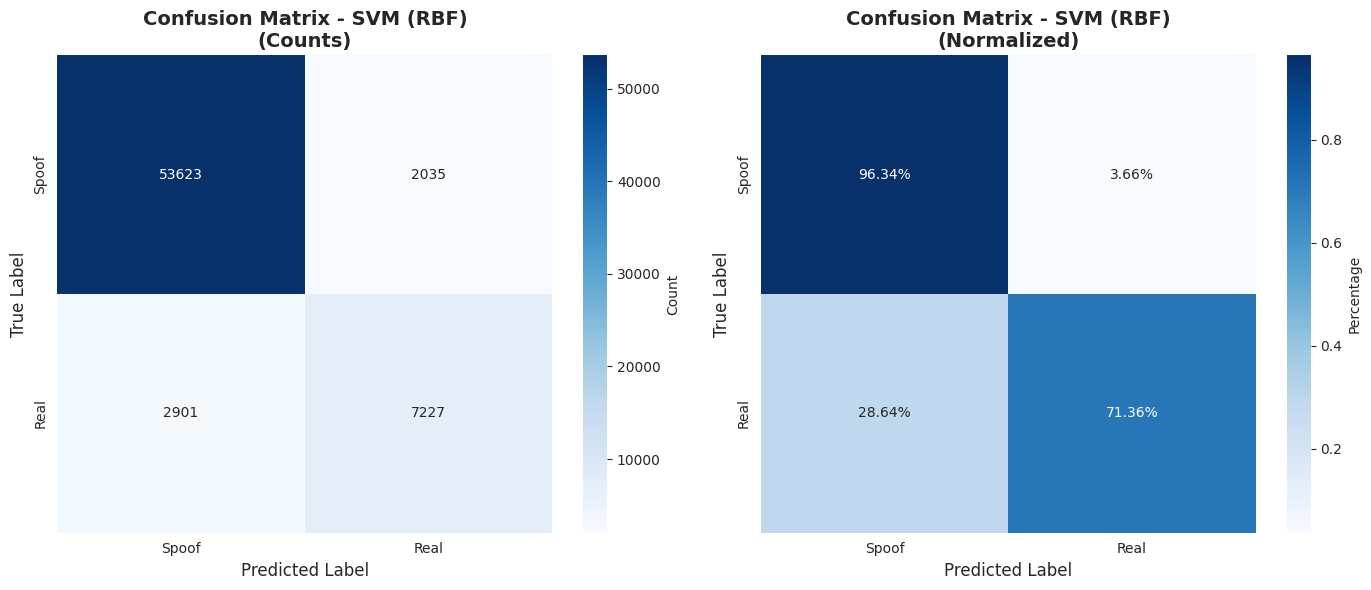


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Spoof     0.9487    0.9634    0.9560     55658
        Real     0.7803    0.7136    0.7454     10128

    accuracy                         0.9250     65786
   macro avg     0.8645    0.8385    0.8507     65786
weighted avg     0.9228    0.9250    0.9236     65786


Detailed Breakdown:
  True Negatives (Correct Spoof):  53623
  False Positives (Spoof as Real): 2035
  False Negatives (Real as Spoof): 2901
  True Positives (Correct Real):   7227

  Spoof Detection Rate: 96.34%
  Real Detection Rate:  71.36%


In [ ]:
# Cell 12: Feature Contribution Analysis
def analyze_feature_importance(model, X, feature_names):
    """
    Analyze which features KAN relies on most
    by measuring sensitivity
    """
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    
    importances = []
    
    for i in range(X.shape[1]):
        # Perturb feature i
        X_perturbed = X_tensor.clone()
        X_perturbed[:, i] = 0  # Set to mean (0 after normalization)
        
        with torch.no_grad():
            orig_output = torch.sigmoid(model(X_tensor))
            pert_output = torch.sigmoid(model(X_perturbed))
            
            # Measure change
            importance = torch.abs(orig_output - pert_output).mean().item()
            importances.append(importance)
    
    # Create dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return importance_df

importance_df = analyze_feature_importance(model, X_test_scaled, feature_cols)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Sensitivity Analysis)")
print("="*60)
print(importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='coral')
plt.xlabel('Importance (Sensitivity)', fontsize=12)
plt.title('KAN Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Discover Novel Patterns - Interaction Analysis
def analyze_feature_interactions(model, feature_names, resolution=50):
    """
    Analyze pairwise feature interactions discovered by KAN
    """
    print("\n" + "="*60)
    print("🔬 DISCOVERING FEATURE INTERACTIONS")
    print("="*60)
    
    # Create grid for two most important features
    top_features = importance_df.head(2)['Feature'].values
    idx1 = feature_cols.index(top_features[0])
    idx2 = feature_cols.index(top_features[1])
    
    print(f"\nAnalyzing interaction between:")
    print(f"  1. {top_features[0]}")
    print(f"  2. {top_features[1]}")
    
    # Create meshgrid
    x1_range = np.linspace(-2, 2, resolution)
    x2_range = np.linspace(-2, 2, resolution)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    # Create input with other features at mean (0)
    predictions = np.zeros((resolution, resolution))
    
    model.eval()
    for i in range(resolution):
        for j in range(resolution):
            x_sample = np.zeros(8)
            x_sample[idx1] = X1[i, j]
            x_sample[idx2] = X2[i, j]
            
            with torch.no_grad():
                x_tensor = torch.FloatTensor(x_sample).unsqueeze(0).to(device)
                pred = torch.sigmoid(model(x_tensor)).item()
                predictions[i, j] = pred
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(X1, X2, predictions, levels=20, cmap='RdYlGn')
    plt.colorbar(contour, label='P(Real)')
    
    # Add decision boundary
    ax.contour(X1, X2, predictions, levels=[0.5], colors='black', linewidths=3)
    
    ax.set_xlabel(top_features[0], fontsize=12)
    ax.set_ylabel(top_features[1], fontsize=12)
    ax.set_title(f'Decision Surface: {top_features[0]} vs {top_features[1]}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return predictions, X1, X2

predictions, X1, X2 = analyze_feature_interactions(model, feature_cols)